In [2]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
    news = requests.get(url, headers=headers)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

url_list = make_urllist(2, 105, 20231128)
print('뉴스 기사의 개수: ',len(url_list))

idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

뉴스 기사의 개수:  40


In [4]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.title)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

In [6]:
# 코드 리스트
code_list = [102, 103, 105]
code_list

[102, 103, 105]

In [8]:
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

# 크롤링

# df = make_total_data(1, code_list, 20231225)
# df.sample(10)

In [10]:
# 데이터 저장하기

import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
# csv_path = os.getenv("HOME") + "/aiffel/news_crawler/240111_news_data.csv"
# df.to_csv(csv_path, index=False)

# if os.path.exists(csv_path):
#   print('{} File Saved!'.format(csv_path))

# 데이터 불러오기

csv_path = os.getenv("HOME") + "/aiffel/news_crawler/240111_news_data.csv"
df = pd.read_table(csv_path, sep=',')
df.head()
print(len(df))

# 데이터 합치기
csv_path_new = os.getenv("HOME") + "/aiffel/news_crawler/merged_file_crawl.csv"
new_df = pd.read_csv(csv_path_new)
combined_df = pd.concat([df, new_df], ignore_index=True)

df.head()
print(len(combined_df))
len(df)

#새로운 데이터 저장
csv_path_m = os.getenv("HOME") + "/aiffel/news_crawler/merged++.csv"
# df.to_csv(csv_path, index=False)
combined_df.to_csv(csv_path_m, index=False)


# 새로운 데이터 다시 불러오기

csv_path = os.getenv("HOME") + "/aiffel/news_crawler/merged++.csv"
df = pd.read_table(csv_path_m, sep=',')


print(len(df))


5820
6906
6906


/tmp/ipykernel_93/1682531284.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


news    5
code    0
dtype: int64
뉴스 기사의 개수:  5357
    code  count
0  IT/과학   1639
1     사회   1978
2  생활/문화   1740


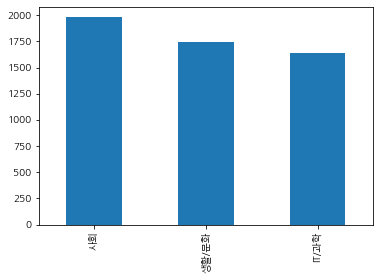

In [11]:
# 데이터 정제
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

print(df.isnull().sum())

# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

# 데이터 탐색

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')

# 실제 개수 확인
print(df.groupby('code').size().reset_index(name = 'count'))

In [12]:
# 토큰화 (자연어 처리를 위한 특정 단위)
# 대표적인 한국어 형태소 분석기로는 KoNLPy, kakao/khaiii, Mecab 등이 있음

#Hannanum 으로 바꿈

from konlpy.tag import Mecab
from konlpy.tag import Hannanum

tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
# tokens = tokenizer.morphs(kor_text)
# print(tokens)


In [13]:
# 불용어 제거

# 불용어 정의
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']


In [14]:
# 불용어 추가하기

import requests

stopwords_added = []
# URL of the raw text file on GitHub
url = 'https://gist.githubusercontent.com/chulgil/d10b18575a73778da4bc83853385465c/raw/a1a451421097fa9a93179cb1f1f0dc392f1f9da9/stopwords.txt'

# Fetching the content of the file
response = requests.get(url)

# Ensure the request was successful
if response.status_code == 200:
    stopwords_added = response.text.splitlines()
else:
    print("Failed to retrieve the file")

# Print the type to check if it's a list
print(type(stopwords_added))

# Combine the two lists of stopwords
stopwords_combined = stopwords_added + stopwords  # Use + operator to combine lists
print(len(stopwords_combined))

# 전처리
def preprocessing(data):
    text_data = []

    for index, sentence in enumerate(data):
        try:
            #- 토큰화
            temp_data = tokenizer.morphs(sentence)
            #- 불용어 제거
            temp_data = [word for word in temp_data if word not in stopwords]
            text_data.append(' '.join(temp_data))
        except Exception as e:
#             print(f"Error at index {index}: {sentence}\nError: {e}")
            text_data.append('')  # Append an empty string or some placeholder
            continue  # Continue with the next iteration

    return text_data

# Example usage
text_data = preprocessing(df['news'])

# Example usage
text_data = preprocessing(df['news'])
print(text_data[5356])
print(len(text_data))



<class 'list'>
626
엔 씨 종료 게임 통 큰 환 불월 구매 개봉 아이템 도 포함
5357


In [15]:
# 머신 러닝

# 머신 러닝 도구 임포트
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

#- 훈련 데이터와 테스트 데이터를 분리합니다.
# sklearn 에서 훈련/테스트 데이터 분리해주는 함수 train_test_split
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

# 분리된 데이터 개수 확인
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))


훈련용 뉴스 기사의 개수 : 4017
테스트용 뉴스 기사의 개수 :  1340
훈련용 레이블의 개수 :  4017
테스트용 레이블의 개수 :  1340


In [16]:
# 딥러닝 자연어 처리 TF-IDF

# fit_transform() 함수는 fit과 transform을 연이어 수행하는 함수로, 
# CountVectorizer.fit_transform()은 단어 데이터를 학습하고 문서 데이터를 document-form matrix로 변환하는 두 가지 작업을 해 줍니다.

#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [17]:
# 테스트

# 텍스트를 입력하면 자동으로 TF-IDF 벡터로 바꾸는 전처리 함수
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

# 테스트 1
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
# ['사회']

# 점수 측정
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

['사회']
              precision    recall  f1-score   support

       IT/과학       0.76      0.79      0.77       420
          사회       0.78      0.84      0.81       483
       생활/문화       0.72      0.64      0.68       437

    accuracy                           0.76      1340
   macro avg       0.76      0.76      0.75      1340
weighted avg       0.76      0.76      0.76      1340

